In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from joblib import dump

In [ ]:
path = './'

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))

In [4]:
# import data
data = pd.read_csv(path + 'data.csv')

In [5]:
data = data.set_index('id').drop('genres', axis=1)

In [6]:
data.head()

,title,overview,genre
id,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation
8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy


In [12]:
data = data[~data['overview'].isnull()]
data.shape

(42324, 3)

In [13]:
train, test = train_test_split(data, test_size=0.1, random_state=17)

In [14]:
train.shape, test.shape

((38091, 3), (4233, 3))

In [9]:
tfidf = StemmedTfidfVectorizer(stop_words=stop_words)

In [15]:
train_tfidf = tfidf.fit_transform(train['overview'])

In [16]:
train_tfidf.shape

(38091, 51592)

### Features Reduction

In [1]:
n = 2000
svd = TruncatedSVD(n_components=n, random_state=11)
svd.fit_transform(train_tfidf)
var = np.cumsum(svd.explained_variance_ratio_*100)

NameError: name 'TruncatedSVD' is not defined

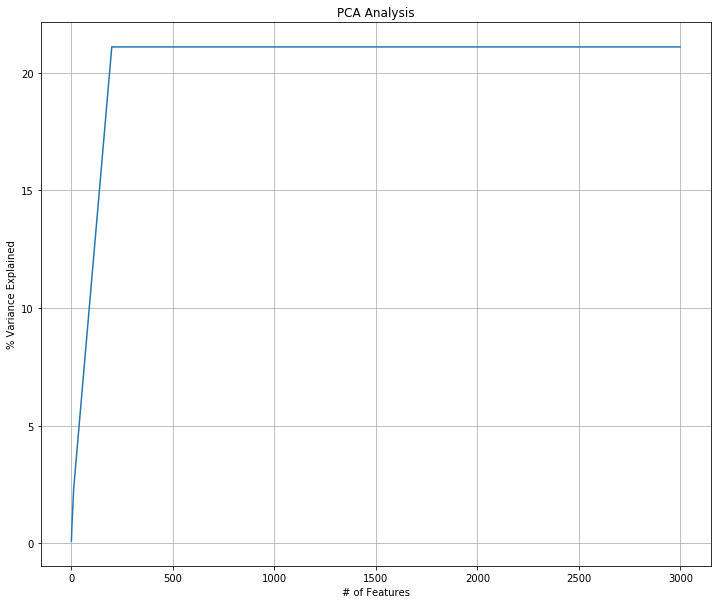

In [18]:
plt.figure(figsize=(12,10))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)
plt.grid()

In [25]:
max(var), np.argmax(var)

(21.10000000000003, 199)

In [29]:
svd = TruncatedSVD(n_components=500, random_state=11)
X_train = svd.fit_transform(train_tfidf)
print(sum(svd.explained_variance_ratio_))

0.27361392133286544


In [33]:
y_train = train['genre'].values
y_train.shape, X_train.shape

((38091,), (38091, 500))

In [34]:
train['genre'].value_counts()

Drama              10636
Comedy              7661
Action              4024
Documentary         3026
Horror              2368
Crime               1503
Thriller            1488
Adventure           1336
Romance             1053
Animation            997
Fantasy              630
Science Fiction      560
Mystery              500
Family               452
Music                433
Western              400
TV Movie             346
War                  327
History              243
Foreign              108
Name: genre, dtype: int64

### Model Selection

In [35]:
# model selection
parameters = {'n_estimators': [50, 70, 100],
              'class_weight': ['balanced', None],
              'max_depth': [20, 35, 50]
             }
gridsearch = GridSearchCV(RandomForestClassifier(), parameters, cv=4, n_jobs=-1, verbose=10)
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 126 out of 128 | elapsed: 22.7min remaining:   21.6s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 22.8min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
gridsearch.best_params_, gridsearch.best_score_

({'class_weight': None, 'max_depth': 35, 'n_estimators': 100},
 0.36971988133679873)

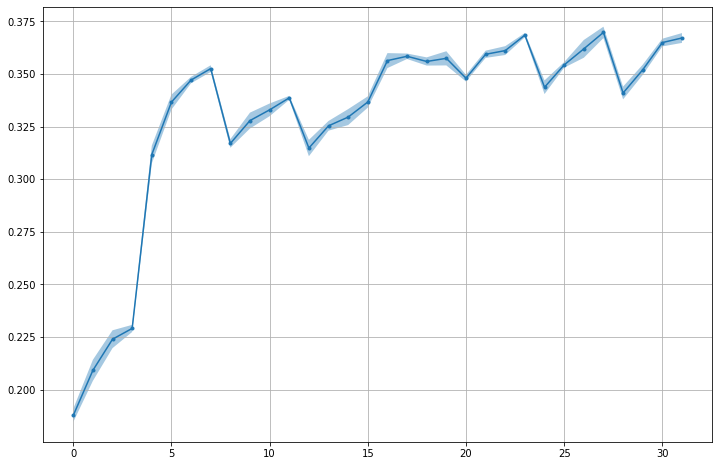

In [44]:
mean_score = gridsearch.cv_results_['mean_test_score']
std_score = gridsearch.cv_results_['std_test_score']

plt.figure(figsize=(12, 8))
plt.plot(mean_score, marker='.')
plt.fill_between(range(len(mean_score)), 
                 mean_score - std_score,
                 mean_score + std_score,
                 alpha=0.4)
plt.grid()

In [45]:
best_hyp_param = gridsearch.best_params_

### Model train and test

In [46]:
movieclf = RandomForestClassifier(**best_hyp_param, random_state=15)

In [47]:
movieclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [48]:
# transform test data using tfidf and svd objects fitted with train data
test_tfidf = tfidf.transform(test['overview'])
X_test = svd.transform(test_tfidf)

In [49]:
y_test = test['genre']

In [50]:
X_test.shape, y_test.shape

((4233, 500), (4233,))

In [51]:
movieclf.score(X_test, y_test)

0.36876919442475786

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [59]:
pd.DataFrame(confusion_matrix(y_test, movieclf.predict(X_test)), 
             columns=movieclf.classes_, 
             index=movieclf.classes_
            )

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Action,119,0,0,60,1,1,255,0,0,0,0,4,0,0,0,1,0,0,0,0
Adventure,25,2,1,21,0,1,113,0,0,0,0,3,0,0,0,0,0,0,0,0
Animation,18,0,3,25,0,3,68,0,0,0,0,0,0,0,0,0,0,0,0,0
Comedy,20,0,1,316,1,13,501,0,0,0,0,3,0,0,0,1,0,0,0,0
Crime,29,0,0,17,1,1,111,0,0,0,0,1,0,0,0,0,0,0,0,0
Documentary,5,0,0,31,0,160,153,0,0,0,0,1,0,0,0,0,0,0,0,0
Drama,33,0,0,176,2,14,941,0,0,0,0,2,0,0,0,0,0,0,0,0
Family,1,0,0,14,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0
Fantasy,7,0,0,9,0,1,46,0,0,0,0,3,0,0,0,0,0,0,0,0
Foreign,0,0,0,1,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0


### Save classifier, tfidf and svd objects

In [57]:
mpath = 'models/'
dump(movieclf, mpath + 'movieclassifier.joblib')
dump(tfidf, mpath + 'tfidf.joblib')
dump(svd, mpath + 'svd.joblib');